# Description of the five tracks of the ESM3 input/output

* Sequence
* Structure
* SS
* SASA
* Function


In [60]:
! pip install esm
! pip install py3Dmol
! pip install matplotlib
! pip install dna-features-viewer
! pip install -U transformers==4.48.1

# Load Libraries

In [ ]:

from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig
from transformers import AutoModel
from biotite.database import rcsb
from esm.utils.structure.protein_chain import ProteinChain
from esm.utils.types import FunctionAnnotation
from biotite.structure import annotate_sse
import py3Dmol
import vis_helper
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Create the ESMProtein object

Proteins: 1cm4 or 104M

In [78]:
pdb_id = "1cm4"
chain_id = "A"
str_io = rcsb.fetch(pdb_id, "pdb")
protein_chain = ProteinChain.from_pdb(str_io, chain_id=chain_id, id=pdb_id)
protein = ESMProtein.from_protein_chain(protein_chain)

print(protein.sequence)

LTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMT


In [79]:
print(protein.coordinates.shape)

torch.Size([143, 37, 3])


# Visualize Protein Structure

In [80]:
# Visualize the protein structure using py3Dmol
def visualize_pdb(pdb_string):
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    view.zoomTo()
    view.render()
    view.center()
    return view

# Visualize the protein structure in 3D using the coordinates
def visualize_3D_coordinates(coordinates):
    """
    This uses all Alanines
    """
    protein_with_same_coords = ESMProtein(coordinates=coordinates)
    # pdb with all alanines
    pdb_string = protein_with_same_coords.to_pdb_string()
    return visualize_pdb(pdb_string)

# Visualize the protein structure in 3D using the ESMProtein object
def visualize_3D_protein(protein):
    pdb_string = protein.to_pdb_string()
    return visualize_pdb(pdb_string)

In [81]:
# visualize from just the coordinates
visualize_3D_coordinates(protein.coordinates)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [82]:
# visualize from sequence and coordinates
visualize_3D_protein(protein)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Secondary Structure

In [83]:
def get_approximate_ss(protein_chain: ProteinChain):
	"""
	Get approximate secondary structure elements (SSE) for a given protein chain.

	Args:
		protein_chain (ProteinChain): The protein chain to analyze.

	Returns:
		str: The secondary structure annotation string in ESM3 format.
	"""
	# Annotate the secondary structure elements
	sse_annotation = annotate_sse(protein_chain.atom_array)
	biotite_ss3_str = "".join(sse_annotation)
	#translate biotite secondary structure to ESM3 format
	translation = str.maketrans({
		"a": "H",  # Helix
		"b": "E",  # Strand
		"c": "C",  # Coil
	})
	esm_ss3 = biotite_ss3_str.translate(translation)
	return esm_ss3

protein.secondary_structure = get_approximate_ss(protein_chain)
print(protein.secondary_structure)

CCHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHHHHHCCCCCHHHHHHCCCCCCCCCCCCCCHHHHHHHHHEEEEECCCCCHHHHHHHHHHCCCCCCCCHHHHHHHHHHHCCCCCHHHHHHHHHHHCCCCCCCCCHHHHHHHHC


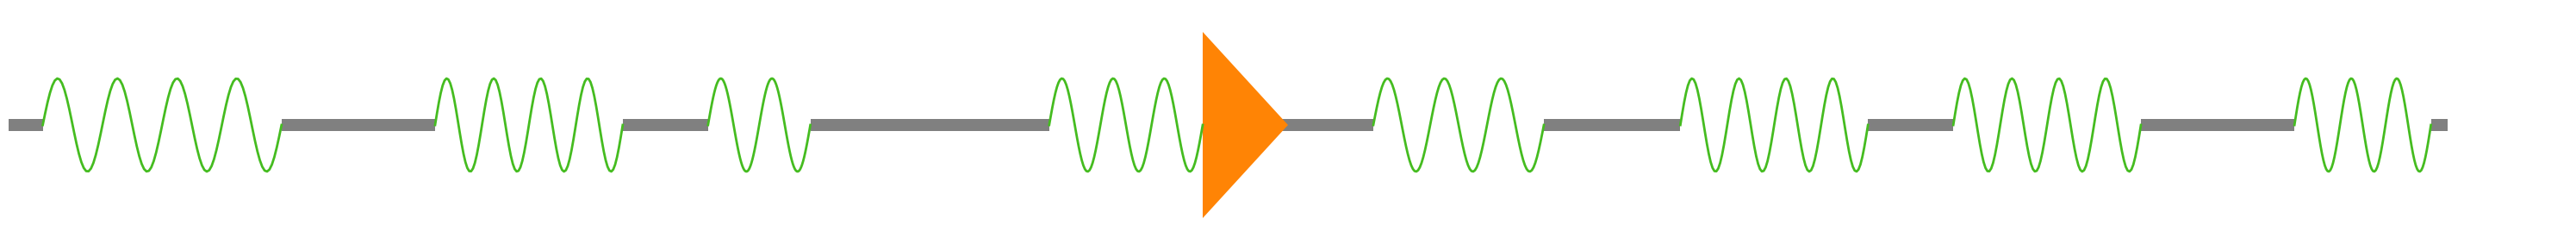

In [84]:
plot_ss8(protein.secondary_structure)

# Function Annotations

In [85]:
def visualize_function_annotations(
    annotations: list[FunctionAnnotation],
    sequence_length: int,
    ax: plt.Axes,
    interpro_=InterPro(),
):
    cmap = colormaps["tab10"]
    colors = [cmap(i) for i in range(len(InterProEntryType))]
    type_colors = dict(zip(InterProEntryType, colors))

    features = []
    for annotation in annotations:
        if annotation.label in interpro_.entries:
            entry = interpro_.entries[annotation.label]
            label = entry.name
            entry_type = entry.type
        else:
            label = annotation.label
            entry_type = InterProEntryType.UNKNOWN

        feature = GraphicFeature(
            start=annotation.start - 1,  # one index -> zero index
            end=annotation.end,
            label=label,
            color=type_colors[entry_type],
            strand=None,
        )
        features.append(feature)

    record = GraphicRecord(
        sequence=None, sequence_length=sequence_length, features=features
    )

    record.plot(figure_width=12, plot_sequence=False, ax=ax)

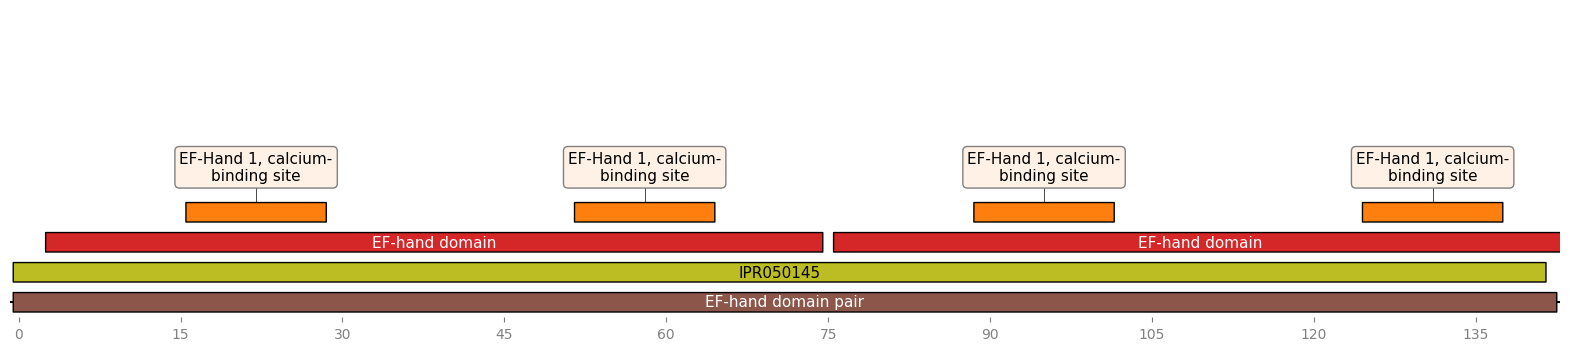

In [ ]:
# function annotations for 104M protein
interpro_function_annotations_104M = [
    FunctionAnnotation(label="IPR000971", start=1, end=147),  # 1 indexed, inclusive;
    FunctionAnnotation(label="IPR002335", start=2, end=153),
    FunctionAnnotation(label="IPR009050", start=1, end=152),
]

# function annotations for 1cm4 protein
interpro_function_annotations_1cm4 = [
    FunctionAnnotation(label="IPR050145", start=1, end=142),  # 1 indexed, inclusive;
    FunctionAnnotation(label="IPR002048", start=4, end=75),
    FunctionAnnotation(label="IPR002048", start=77, end=144),
    FunctionAnnotation(label="IPR011992", start=1, end=143),
    FunctionAnnotation(label="IPR018247", start=17, end=29),
    FunctionAnnotation(label="IPR018247", start=53, end=65),
    FunctionAnnotation(label="IPR018247", start=90, end=102),
    FunctionAnnotation(label="IPR018247", start=126, end=138),
]

fig, ax = plt.subplots(figsize=(20.0, 4.0))
visualize_function_annotations(interpro_function_annotations_1cm4, len(protein), ax)

In [ ]:
#Function Annotations
from esm.tokenization import InterProQuantizedTokenizer


def get_keywords_from_interpro(
    interpro_annotations,
    interpro2keywords=InterProQuantizedTokenizer().interpro2keywords,
):
    keyword_annotations_list = []
    for interpro_annotation in interpro_annotations:
        keywords = interpro2keywords.get(interpro_annotation.label, [])
        keyword_annotations_list.extend(
            [
                FunctionAnnotation(
                    label=keyword,
                    start=interpro_annotation.start,
                    end=interpro_annotation.end,
                )
                for keyword in keywords
            ]
        )
    return keyword_annotations_list


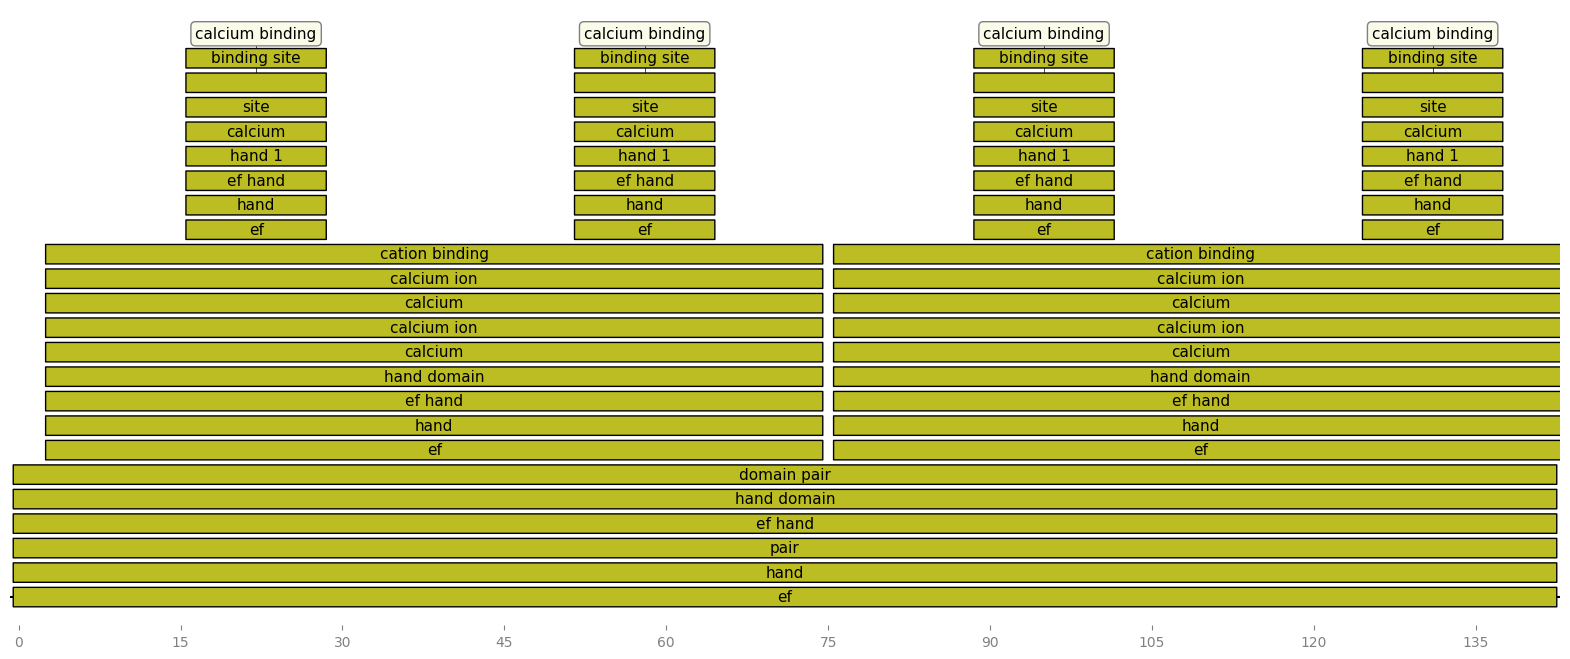

In [88]:
protein.function_annotations = get_keywords_from_interpro(interpro_function_annotations_1cm4)
fig, ax = plt.subplots(figsize=(20.0, 8.0))
visualize_function_annotations(protein.function_annotations, len(protein), ax)

# solvent-accessible surface area

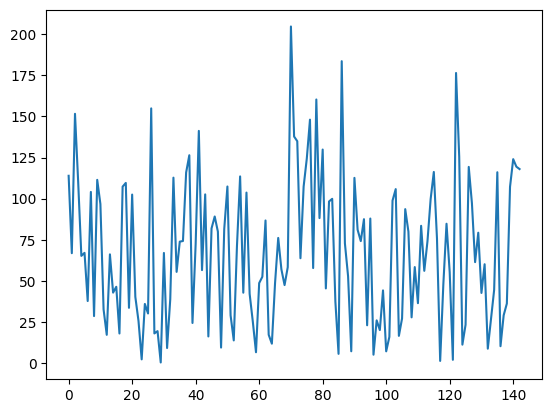

In [ ]:
protein.sasa = protein_chain.sasa()
# Plot the solvent-accessible surface area (SASA)
plt.plot(protein.sasa)

# Visualize SASA in 3D

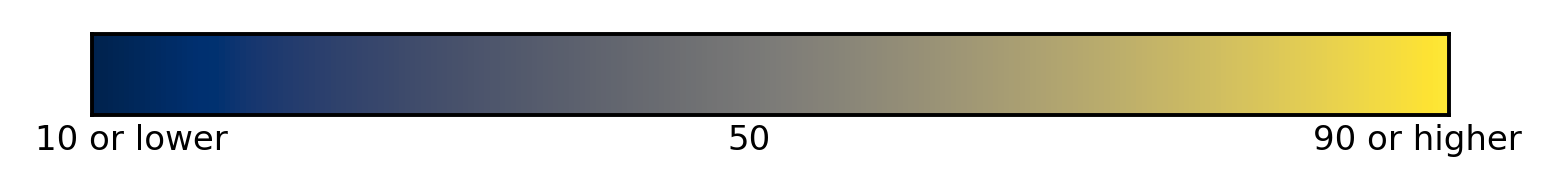

In [94]:
# define which colors map to which values

cmap = colormaps["cividis"]
clip_sasa_lower = 10
clip_sasa_upper = 90


def plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    _, ax = plt.subplots(figsize=(5, 0.3), dpi=350)
    ax.imshow(gradient, aspect="auto", cmap=cmap)
    ax.text(
        0.1,
        -0.3,
        f"{clip_sasa_lower} or lower",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.3,
        f"{(clip_sasa_lower + clip_sasa_upper) // 2}",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        -0.3,
        f"{clip_sasa_upper} or higher",
        va="center",
        ha="left",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper)

In [95]:
# Functions for visualizing SASA as colors on the 3D structure


def get_color_strings(sasa, clip_sasa_lower, clip_sasa_upper, cmap):
    transformed_sasa = np.clip(sasa, clip_sasa_lower, clip_sasa_upper)
    transformed_sasa = (transformed_sasa - clip_sasa_lower) / (
        clip_sasa_upper - clip_sasa_lower
    )
    rgbas = (cmap(transformed_sasa) * 255).astype(int)

    return [f"rgb({rgba[0]},{rgba[1]},{rgba[2]})" for rgba in rgbas]


def visualize_sasa_3D_protein(
    protein, clip_sasa_lower=clip_sasa_lower, clip_sasa_upper=clip_sasa_upper, cmap=cmap
):
    pdb_string = protein.to_pdb_string()
    plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper)
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")

    for res_pos, res_color in enumerate(
        get_color_strings(protein.sasa, clip_sasa_lower, clip_sasa_upper, cmap)
    ):
        view.setStyle(
            {"chain": "A", "resi": res_pos + 1}, {"cartoon": {"color": res_color}}
        )
    view.zoomTo()
    view.render()
    view.center()

    return view

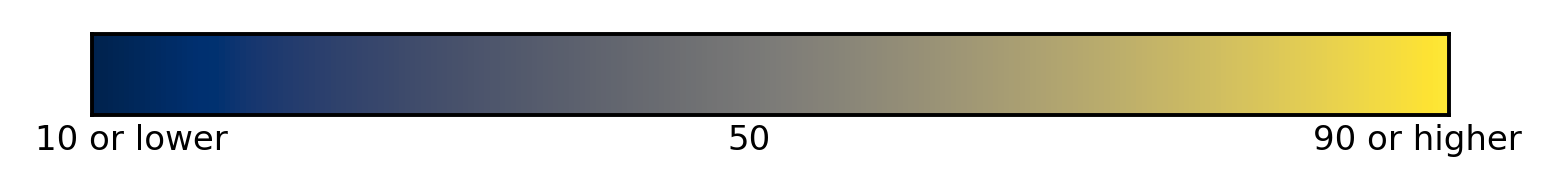

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [96]:
visualize_sasa_3D_protein(protein)

In [ ]:
# Login to Hugging Face Hub
#
login(new_session=False)
model: ESM3InferenceClient = ESM3.from_pretrained("esm3-open").to("cuda") # or "cpu"
